Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4',
       'AcceptedCmp5', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response',
       'age', 'spent', 'children', 'family_size', 'living_with', 'is_parent',
       'education2', 'customer_for'],
      dtype='object')
0
       Variable  Moyenne  Médiane  Minimum  Maximum
0           age    56.10     55.0       29       85
1         spent   605.74    396.0        5     2525
2   family_size     2.60      3.0        1        5
3  customer_for   353.79    356.0        0      699


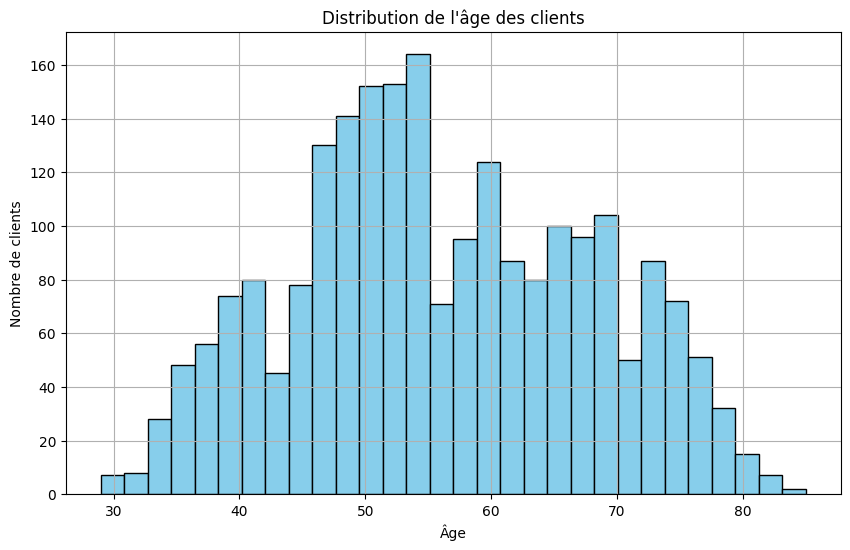

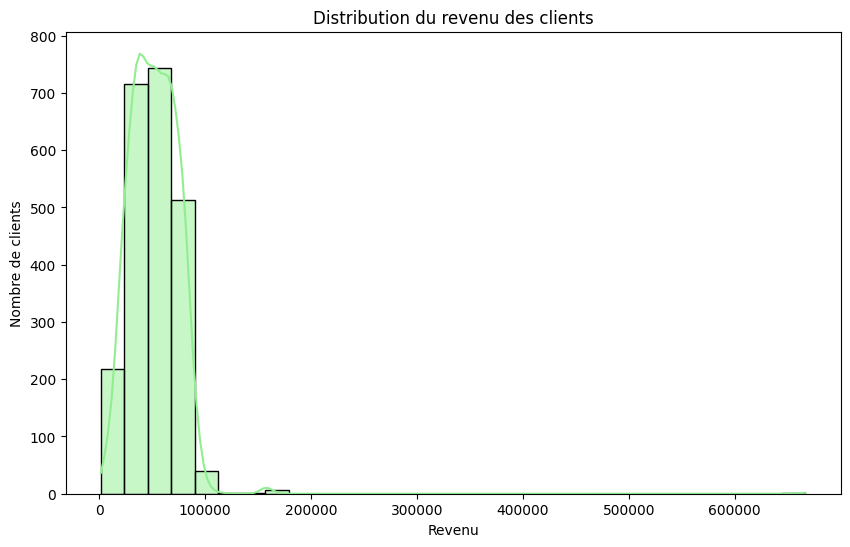

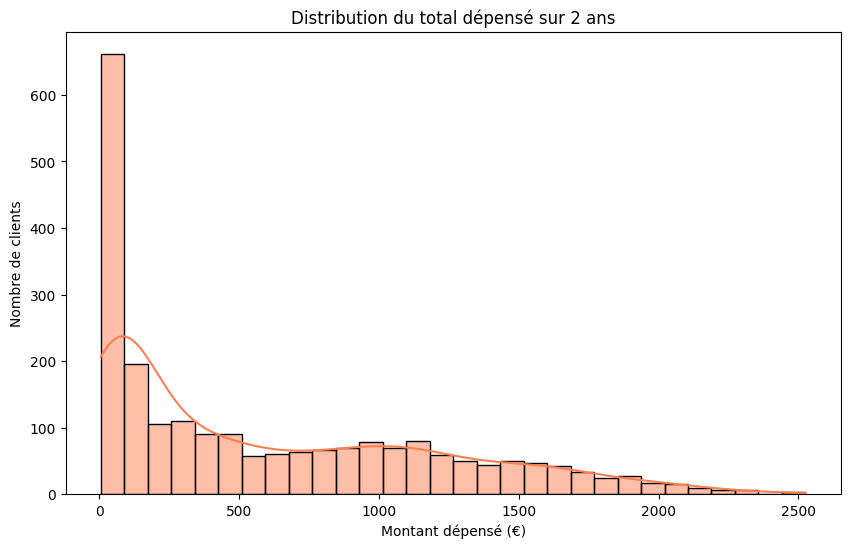

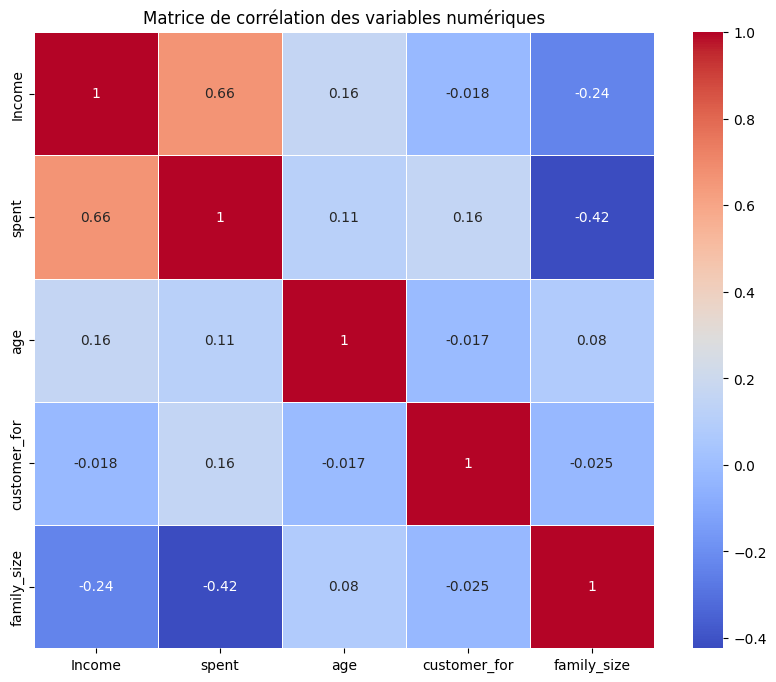

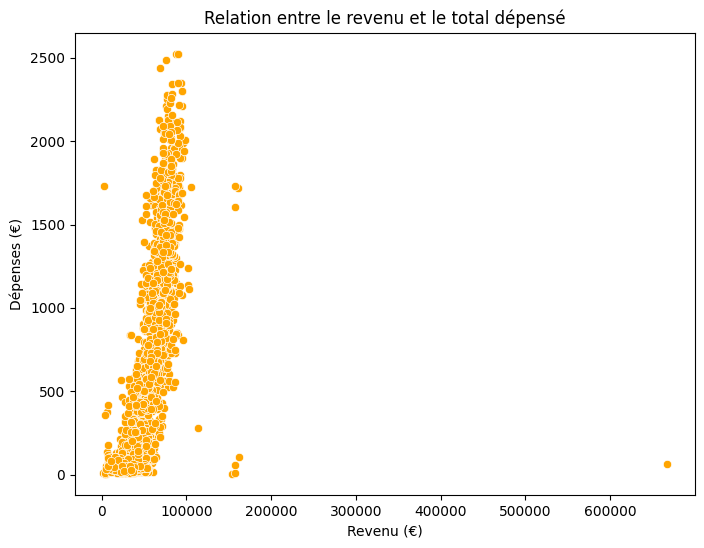

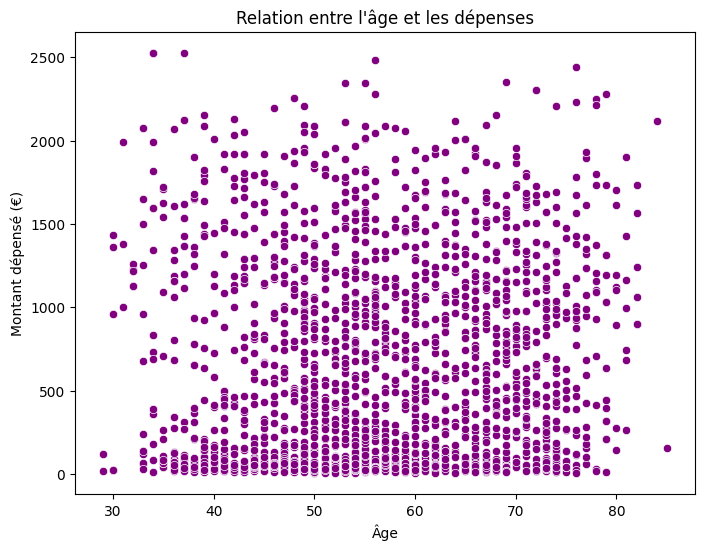

In [11]:
import pandas as pd
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_excel("Market.xlsx", sheet_name="Market")
print(df.columns)

imputer = SimpleImputer(strategy='mean')
df[['Income']] = imputer.fit_transform(df[['Income']])

print(df['Income'].isnull().sum())
df.to_excel("Market_filled.xlsx", index=False)

variables = ['age', 'spent', 'family_size', 'customer_for']

stats = {
    'Variable': [],
    'Moyenne': [],
    'Médiane': [],
    'Minimum': [],
    'Maximum': []
}
for var in variables:
    stats['Variable'].append(var)
    stats['Moyenne'].append(round(df[var].mean(), 2))
    stats['Médiane'].append(round(df[var].median(), 2))
    stats['Minimum'].append(round(df[var].min(), 2))
    stats['Maximum'].append(round(df[var].max(), 2))

summary_df = pd.DataFrame(stats)

print(summary_df)
summary_df.to_excel("Tableau_Analyse_Descriptive.xlsx", index=False)

#Age
plt.figure(figsize=(10,6))
df['age'].hist(bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution de l'âge des clients")
plt.xlabel("Âge")
plt.ylabel("Nombre de clients")
plt.show()

#Revenu
plt.figure(figsize=(10,6))
sns.histplot(df['Income'], bins=30, kde=True, color='lightgreen')
plt.title("Distribution du revenu des clients")
plt.xlabel("Revenu")
plt.ylabel("Nombre de clients")
plt.show()

#Dépenses (spent)
plt.figure(figsize=(10,6))
sns.histplot(df['spent'], bins=30, kde=True, color='coral')
plt.title("Distribution du total dépensé sur 2 ans")
plt.xlabel("Montant dépensé (€)")
plt.ylabel("Nombre de clients")
plt.show()

#Corrélations
plt.figure(figsize=(10,8))
corr = df[['Income', 'spent', 'age', 'customer_for', 'family_size']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Matrice de corrélation des variables numériques")
plt.show()

#Revenu vs Dépenses
plt.figure(figsize=(8,6))
sns.scatterplot(x='Income', y='spent', data=df, color='orange')
plt.title("Relation entre le revenu et le total dépensé")
plt.xlabel("Revenu (€)")
plt.ylabel("Dépenses (€)")
plt.show()


#Âge vs Dépenses
plt.figure(figsize=(8,6))
sns.scatterplot(x='age', y='spent', data=df, color='purple')
plt.title("Relation entre l'âge et les dépenses")
plt.xlabel("Âge")
plt.ylabel("Montant dépensé (€)")
plt.show()



